In [1]:
%load_ext autoreload
%autoreload 2
import torchshow as ts
import os
import cv2
import pickle
from IPython.display import Video
import glob
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import visarl.util.constants as constants

from visarl.src.modules.picanet import Unet
from visarl.util.saliency_util import get_heatmap_from_ann_file
from visarl.train_picanet import picanet_cfg
import visarl.util.general_utils as utils
from visarl.src.modules.mmae import initialize_mmae

sys.path.append(constants.MMAE)

from dataset import MetaworldData, RealWorldData
from torchvision import transforms


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Visualize the saliency predictions

In [3]:
# load in the pretrained saliency predictor
# task = 'drawer-open-v2'
task = "pickup_apple"
cfg = picanet_cfg[2]
model = Unet(cfg).eval()
ckpt_file = os.path.join(constants.ROOT_DIR, f"pretrained_models/{task}/fixation_model_picanet_cfg_2.pt")
assert Path(ckpt_file).exists()
model.load_state_dict(torch.load(ckpt_file))

<All keys matched successfully>

0 249


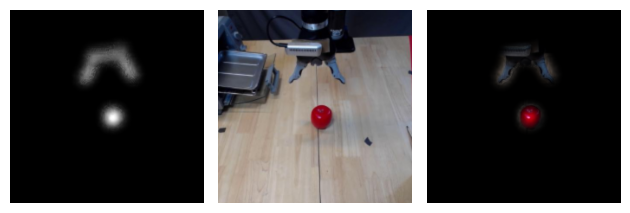

In [40]:
# img = plt.imread("frame_000.png")[:,:,:3]
img = plt.imread("frame_0001.jpg")[:,:,:3]
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA) # HxWxC
img = img.transpose(2,0,1)[None] # 1xCxHxW
print(img.min(), img.max())

with torch.no_grad():
    inp_ = torch.from_numpy(img).float() / 255.0
    pred, _ = model(inp_)
    pred = pred[-1]
    
masked_img = pred.repeat(1,3,1,1) * img
ts.show([pred.squeeze(), img.squeeze(), masked_img.squeeze()]) 

## Visualize the MultiMAE predictions

In [41]:
def make_color(sal):
    sal = sal.squeeze().cpu().detach().numpy()
    heatmap = sal * 255
    heatmap = heatmap.astype("uint8")
    h, w = sal.shape
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Create mask
    threshold = 5
    alpha = 0.7
    mask = np.where(heatmap <= threshold, 1, 0)
    mask = np.reshape(mask, (h, w, 1))
    mask = np.repeat(mask, 3, axis=2)

    # Merge images
    merge = heatmap_color
    merge = merge.astype("uint8")
    saliency_viz = torch.from_numpy(merge / 255.0).unsqueeze(0).permute(0, 3,1,2)
    return saliency_viz

In [4]:
def visualize_predictions(model, in_domains, obs, saliency=None, show=False):
    to_show_rgb = []
    to_show_saliency = []
    with torch.no_grad():
        for i in range(3):
            input_dict = {}
            input_dict["rgb"] = obs.cuda()
            if saliency is None:
                saliency = torch.zeros_like(input_dict["rgb"])[:, 0:1]

            input_dict["saliency"] = saliency

            num_encoded_tokens = 32  # the number of visible tokens
            alphas = 1.0  # Dirichlet concentration parameter

            preds, masks = model.forward(
                input_dict,
                mask_inputs=True,  # True if forward pass should sample random masks
                num_encoded_tokens=num_encoded_tokens,
                alphas=alphas,
            )

            masks_ = masks
            mask_rgb = utils.get_masked_image(utils.denormalize(input_dict["rgb"]), masks_["rgb"])
            pred_img = utils.get_pred_with_input(input_dict["rgb"], preds["rgb"], masks_["rgb"])
        

            if "saliency" in in_domains:
                mask_saliency = utils.get_masked_image(input_dict["saliency"], masks_["saliency"])
                pred_saliency = utils.get_pred_with_input(input_dict["saliency"], preds["saliency"], masks_["saliency"]).cuda()
            

            show_rgb = [
                utils.denormalize(obs) * 255.0,
                mask_rgb * 255.0,
                utils.denormalize(pred_img) * 255.0,
            ]
            if i != 0:
                show_rgb = show_rgb[1:]
        
            show_rgb = list(zip(*show_rgb))
            show_rgb = [list(elem) for elem in show_rgb]
            to_show_rgb.extend(show_rgb[0])
            
            saliency_viz = make_color(saliency)
            
            if "saliency" in in_domains:
                mask_saliency = utils.get_masked_image(saliency_viz, masks_["saliency"])
                pred_saliency = utils.get_pred_with_input(saliency.float(), preds["saliency"], masks_["saliency"]).cuda()
                
                pred_saliency = make_color(pred_saliency)
                    
            if "saliency" in in_domains:
                show_saliency = [saliency_viz, mask_saliency * 255.0, pred_saliency]
                if i != 0:
                    show_saliency = show_saliency[1:]

                show_saliency = list(zip(*show_saliency))
                show_saliency = [list(elem) for elem in show_saliency]
                to_show_saliency.extend(show_saliency[0])
                
        to_show = [to_show_rgb, to_show_saliency]
        return to_show

In [5]:
%%capture
# task = "drawer-open-v2"
task = "pickup_apple"
all_checkpoints = glob.glob(os.path.join(constants.MMAE, "output_dir", f"{task}_mmae_with_saliency", 'checkpoint-*.pth'))
latest_ckpt = -1
for ckpt in all_checkpoints:
    t = ckpt.split('-')[-1].split('.')[0]
    if t.isdigit():
        latest_ckpt = max(int(t), latest_ckpt)
                    
mmae_model = initialize_mmae(
    load_from_ckpt=True, 
    ckpt_path=os.path.join(constants.MMAE, "output_dir", f"{task}_mmae_with_saliency", f"checkpoint-{latest_ckpt}.pth")
)
mmae_model = mmae_model.cuda()

FileNotFoundError: [Errno 2] No such file or directory: '/data/anthony/MultiMAE/output_dir/pickup_apple_mmae_with_saliency/checkpoint--1.pth'

In [33]:
# upsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(224 / 64, 224 / 64), mode="nearest").to("cuda")
# downsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(64 / 224, 64 / 224), mode="nearest").to("cuda")

# transform_train = transforms.Compose(
#     [
#         # transforms.Resize(224),
#         # lambda x: x / 255.0,  # this is only if the image isn't normalized already
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )

# img_input = transform_train(torch.from_numpy(img)).cuda()
# img_input = downsample_m(img_input)
# saliency_input = downsample_m(pred).cuda()
# print(img_input.shape, saliency_input.shape)

# to_show = visualize_predictions(
#     mmae_model, 
#     ["rgb", "saliency"], 
#     img_input, 
#     saliency_input, 
#     show=False
# )
# ts.show(to_show, tight_layout=True, figsize=(20, 2*3))

tensor(-2.1179, device='cuda:0') tensor(2.5354, device='cuda:0')
torch.Size([1, 3, 224, 224]) torch.Size([1, 1, 224, 224])


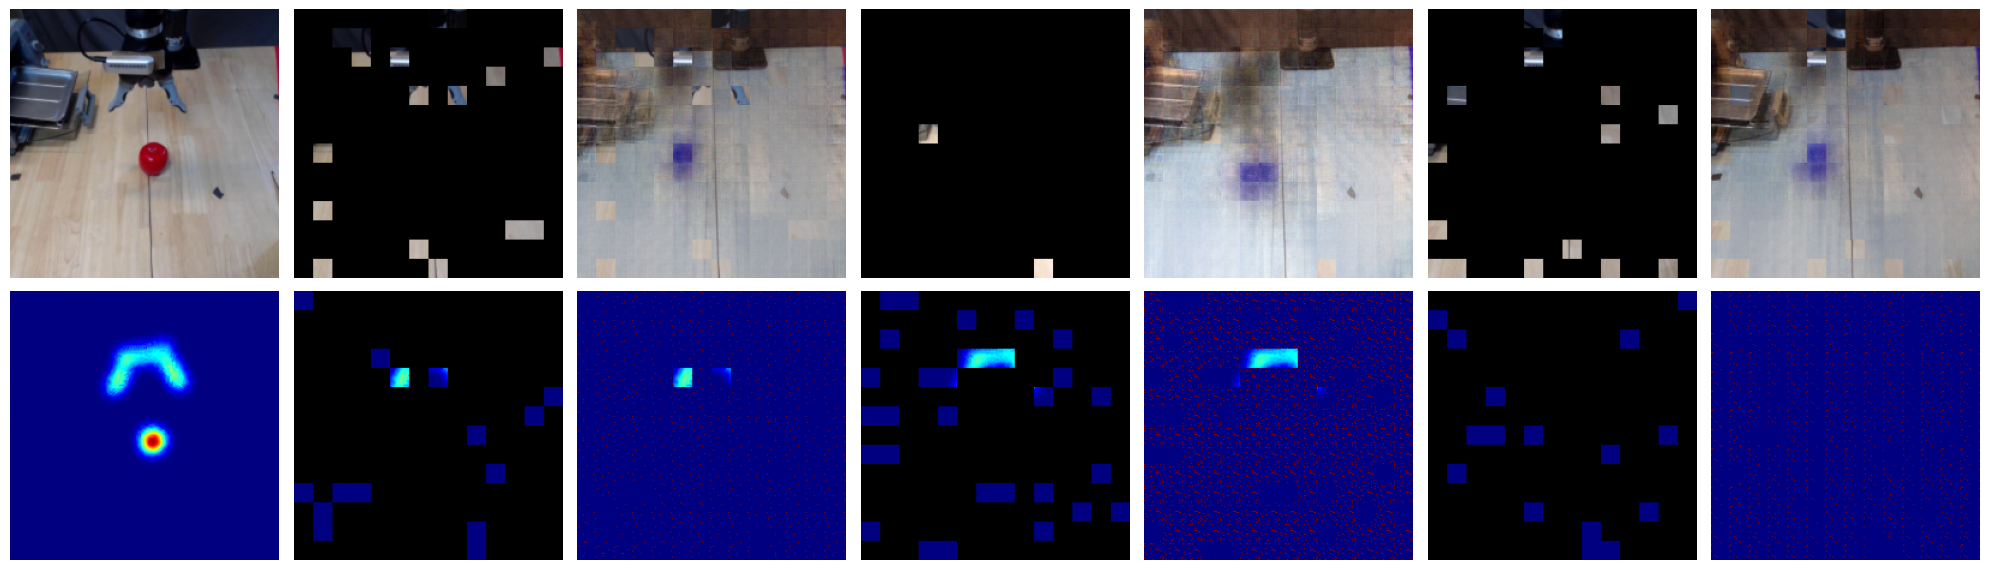

In [48]:
# upsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(224 / 64, 224 / 64), mode="nearest").to("cuda")
# downsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(64 / 224, 64 / 224), mode="nearest").to("cuda")

transform_train = transforms.Compose(
    [
        # transforms.Resize(224),
        lambda x: x / 255.0,  # this is only if the image isn't normalized already
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img_input = transform_train(torch.from_numpy(img)).cuda()
# img_input = downsample_m(img_input)
# saliency_input = downsample_m(pred).cuda()
saliency_input = pred.cuda()
print(img_input.min(), img_input.max())
print(img_input.shape, saliency_input.shape)

to_show = visualize_predictions(
    mmae_model, 
    ["rgb", "saliency"], 
    img_input, 
    saliency_input, 
    show=False
)
ts.show(to_show, tight_layout=True, figsize=(20, 2*3))